In [ ]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import seaborn as sns
#import rpy2.rinterface_lib.callbacks
import logging
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import  LogisticRegression
from keras.models import load_model
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from functools import partial
from sklearn.ensemble import StackingClassifier
from bayes_opt import BayesianOptimization
#from rpy2.robjects import pandas2ri
from joblib import dump, load
import pickle
#import anndata2ri
import anndata
from joblib import Parallel, delayed
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import scanpy as sc
import pandas as pd

import anndata
import scipy as sp
from scipy.stats import spearmanr
from skopt import gp_minimize
from skopt.space import Real
import importlib
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")
import pickle as pkl
import subprocess
import sys
from sklearnex import patch_sklearn 
patch_sklearn()
from tensorflow.keras import regularizers
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import skimage
def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

-----
anndata     0.9.1
scanpy      1.9.3
-----
PIL                         9.4.0
anndata2ri                  1.1
anyio                       NA
asciitree                   NA
asttokens                   NA
astunparse                  1.6.3
attr                        22.1.0
babel                       2.11.0
backcall                    0.2.0
backports                   NA
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.5
brotli                      NA
certifi                     2023.05.07
cffi                        1.15.1
chardet                     4.0.0
charset_normalizer          2.0.4
cloudpickle                 2.2.1
colorama                    0.4.6
comm                        0.1.2
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.12.0
dask                        2022.02.1
dateutil                    2.8.2
debugpy                     1.6.6
decorator                   5.1.1
defusedxml  

In [8]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths('C:\\Users\\Ran\\AppData\\Local\\R\\win-library\\4.2'))

# Load all the R libraries we will be using in the notebook
library(scran)
library(Seurat)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(ggplot2)
library(plyr)
library(MAST)
library(monocle3)

Exception ignored from cffi callback <function _consolewrite_ex at 0x00000234A53BDA60>:
Traceback (most recent call last):
  File "C:\Users\Ran\anaconda3\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "C:\Users\Ran\anaconda3\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 138, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xd4 in position 1: invalid continuation byte


In [1]:
my_palette = ['#0351A8','#8CB0E0','#D56D11','#FFBB78','#234E08','#53CB8B','#D30083','#CB788D','#4E195A','#C58CCF','#AA290F','#B03FD1','#E8BCCF','#64605F','#B2AD9A','#D2D30B','#D1BD4F','#06DCF2','#9EDAE5','#517219','#5B43CF','#D92F24','#FFD900','#002F33','#B8A3A3']

In [2]:
bi_palette = ['#E8D2A0','#030200']

In [3]:
rb_palette = ['#FF1E00','#0073FF']

## Data Processing

In [7]:
count_raw= pd.read_csv('GSM4288255_Raw_UMI_genes.tsv.gz',sep='\t',index_col=0)

In [56]:
count = sp.sparse.csr_matrix(count_raw.values)

In [86]:
import anndata
adata = anndata.AnnData(X = count)
adata.var_names = count_raw.columns
adata.obs_names = count_raw.index

In [89]:
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)
adata.obs['log10GenesPerUMI'] = np.log10(adata.obs['n_genes'])/np.log10(adata.obs['n_counts']) #This is the complexity

mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
adata.obs['mt_frac'] = np.array(adata.X[:, mt_gene_mask].sum(1).ravel())[0]/adata.obs['n_counts']
ribo_gene_mask = [gene.startswith('RPL') or gene.startswith('RPS') for gene in adata.var_names]
adata.obs['ribo_frac'] = np.array(adata.X[:, ribo_gene_mask].sum(1).ravel())[0]/adata.obs['n_counts']
print('Number of cells before T filter: {:d}'.format(adata.n_obs))
adata = adata[np.array(adata[:,'CD3D'].X.A>0)|np.array(adata[:,'CD3E'].X.A>0)|np.array(adata[:,'CD3G'].X.A>0)|np.array(adata[:,'CD247'].X.A>0),:]
adata = adata[np.array(adata[:,'CD19'].X.A==0),:]
print('Number of cells after T filter: {:d}'.format(adata.n_obs))

Number of cells before T filter: 5559
Number of cells after T filter: 4002


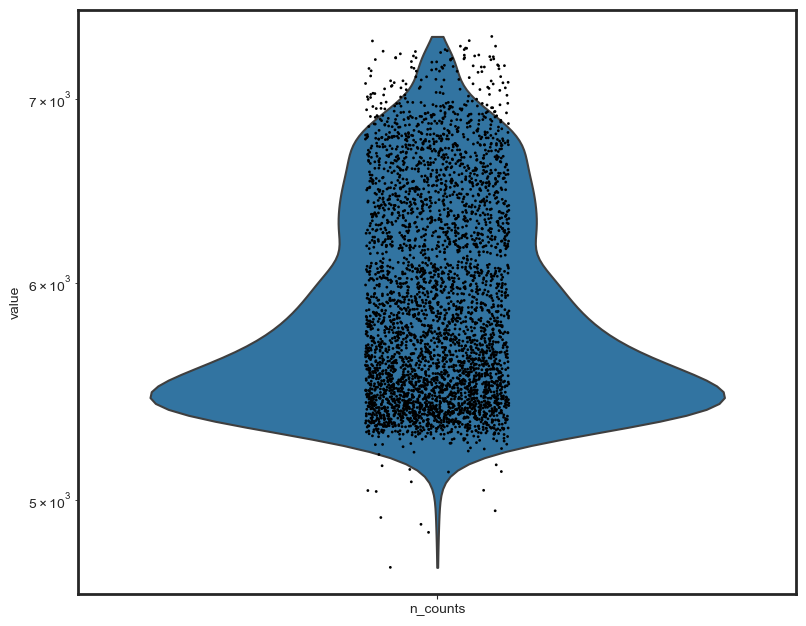

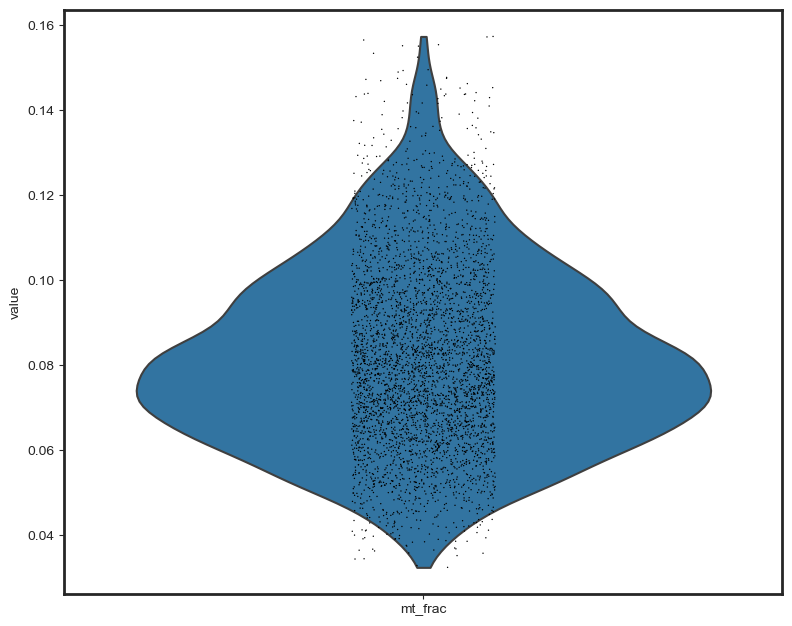

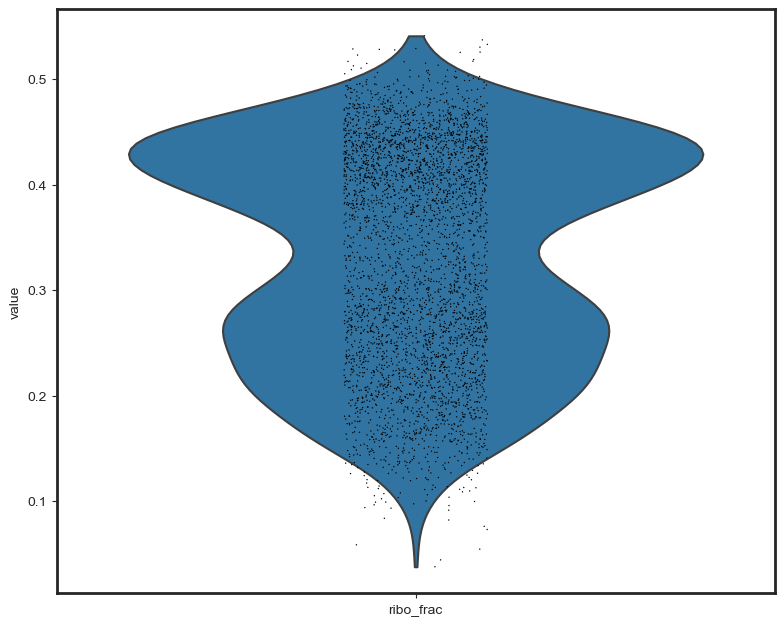

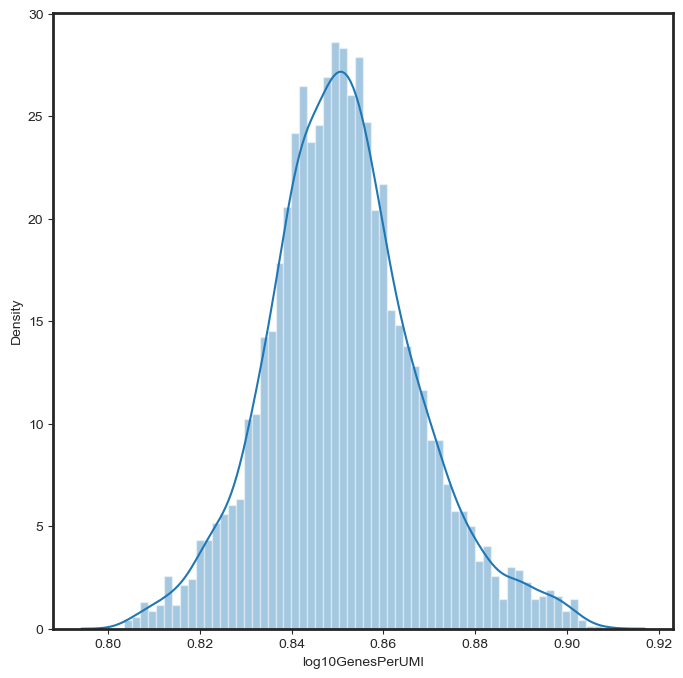

In [90]:
# Quality control - plot QC metrics
t1 = sc.pl.violin(adata, 'n_counts', size=2, log=True, cut=0)
t2 = sc.pl.violin(adata, 'mt_frac')
t3 = sc.pl.violin(adata, 'ribo_frac')
t4 = sns.distplot(adata.obs['log10GenesPerUMI'],bins = 60)

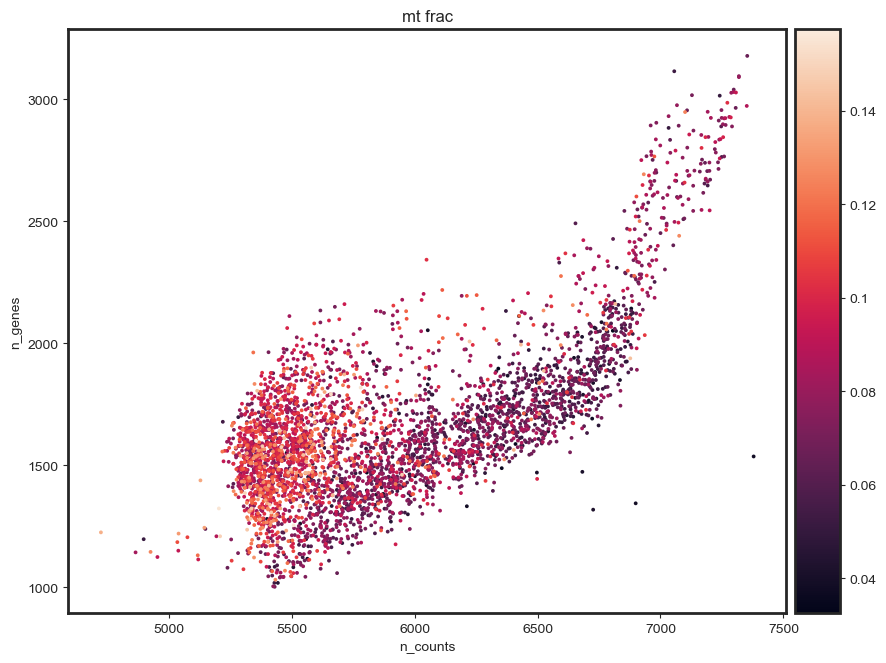

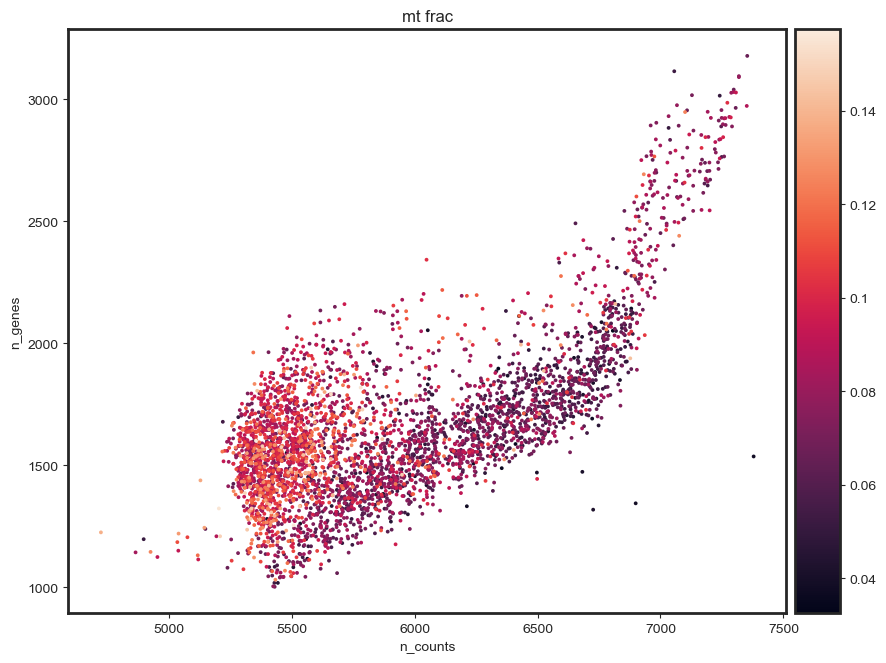

In [91]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac')
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac')

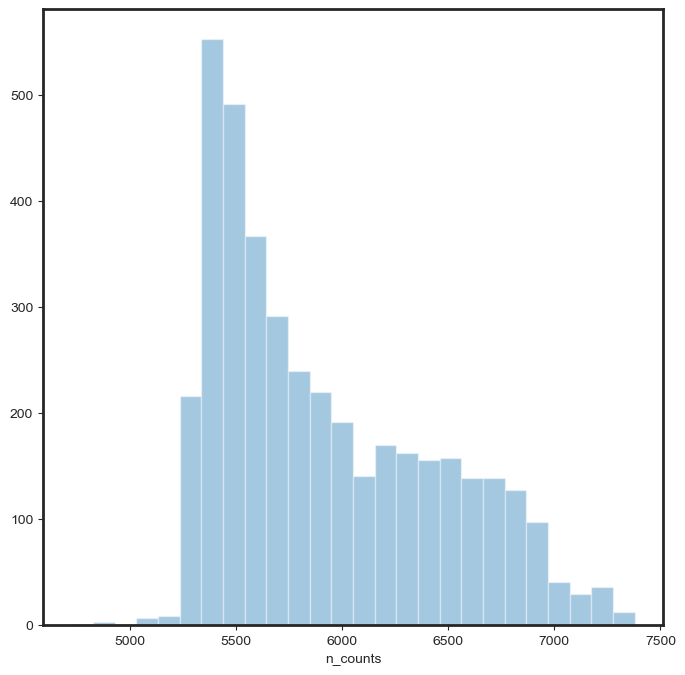

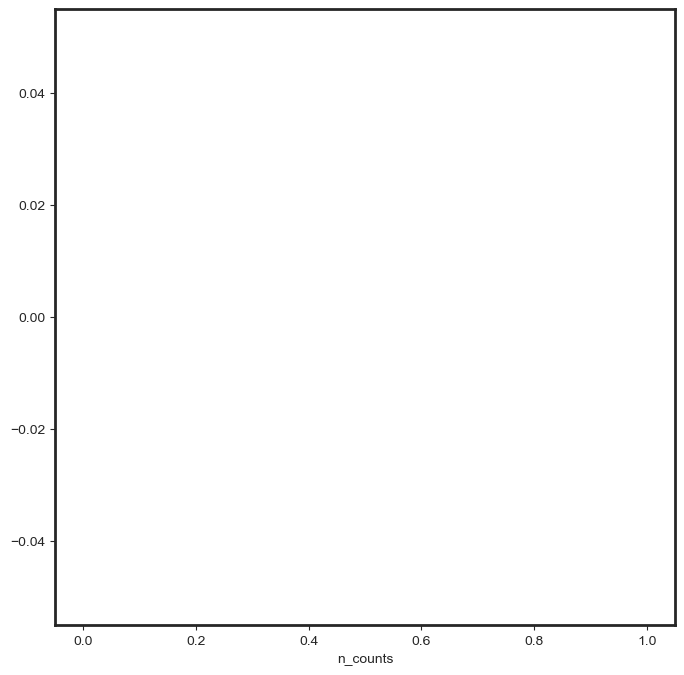

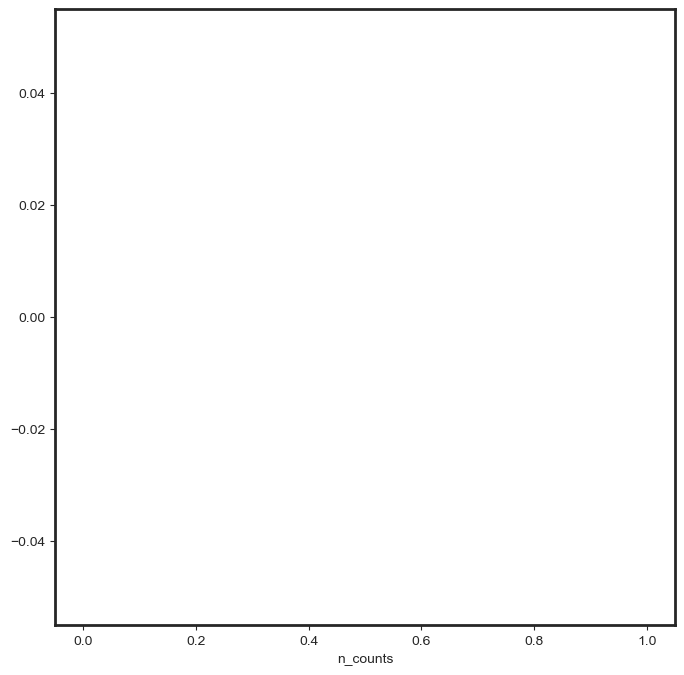

In [92]:
#Thresholding decision: counts
p3 = sns.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], kde=False, bins=60)
plt.show()

p5 = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde=False, bins=60)
plt.show()

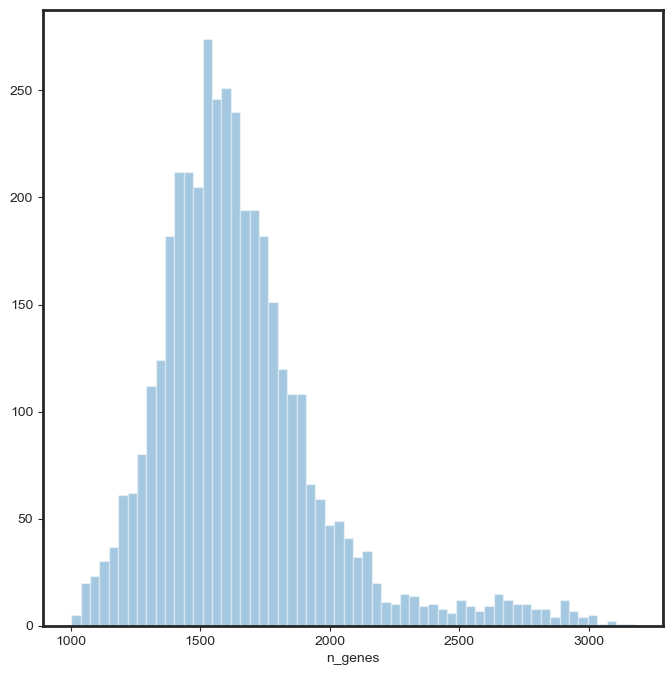

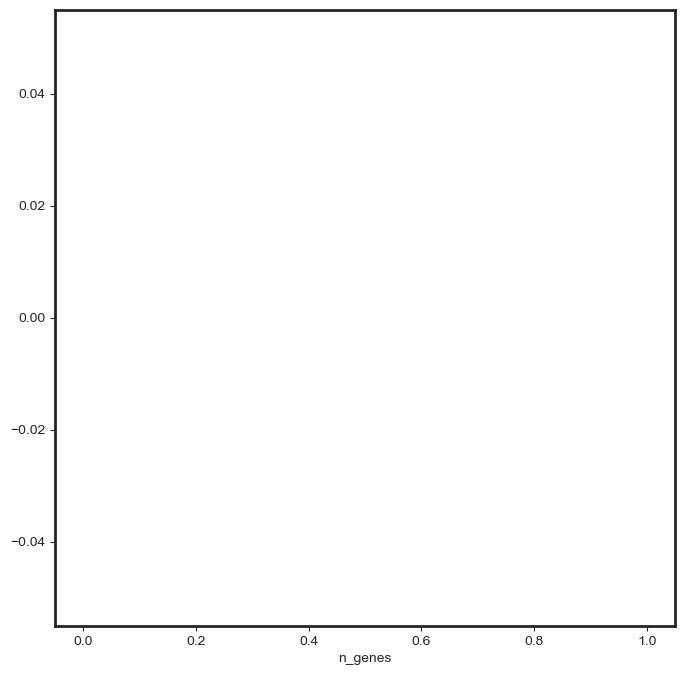

In [93]:
p6 = sns.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sns.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60)
plt.show()

In [94]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 1000)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

#sc.pp.filter_cells(adata, max_counts = 15000)
#print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['ribo_frac'] > 0.05]
print('Number of cells after ribo filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 200)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

#adata = adata[adata.obs['log10GenesPerUMI'] > 0.8]
#print('Number of cells after complexity filter: {:d}'.format(adata.n_obs))

Total number of cells: 4002
Number of cells after min count filter: 4002
Number of cells after MT filter: 4002
Number of cells after ribo filter: 4000
Number of cells after gene filter: 4000


In [34]:
clf = doubletdetection.BoostClassifier(n_components = 50, n_top_var_genes = 3000)
# raw_counts is a cells by genes count matrix
labels = clf.fit(adata_group[1].X.A).predict()
# higher means more likely to be doublet
scores = clf.doublet_score()

  0%|          | 0/10 [00:00<?, ?it/s]

computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.`
    with n_comps=50
    finished (0:00:00)
computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.`
    with n_comps=50
    finished (0:00:00)
computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.`
    with n_comps=50
    finished (0:00:00)
computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.`
    with n_comps=50
    finished (0:00:00)
computing PCA
Note that scikit-learn's randomized PCA might not be exactly repro

In [ ]:
print('Number of cells before T filter: {:d}'.format(adata_group[1].n_obs))
adata_group[1] = adata_group[1][labels == 0]
print('Number of cells after T filter: {:d}'.format(adata_group[1].n_obs))

In [95]:
sc.pp.filter_genes(adata, min_cells = 2)

filtered out 1239 genes that are detected in less than 2 cells


In [96]:
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)
adata.obs['log10GenesPerUMI'] = np.log10(adata.obs['n_genes'])/np.log10(adata.obs['n_counts'])

mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
adata.obs['mt_frac'] = np.array(adata.X[:, mt_gene_mask].sum(1).ravel())[0]/adata.obs['n_counts']
ribo_gene_mask = [gene.startswith('RPL') or gene.startswith('RPS') for gene in adata.var_names]
adata.obs['ribo_frac'] = np.array(adata.X[:, ribo_gene_mask].sum(1).ravel())[0]/adata.obs['n_counts']

In [97]:
adata_forcycle = adata.copy()
sc.pp.normalize_total(adata_forcycle, key_added = 'normalization_factors')
sc.pp.log1p(adata_forcycle)

normalizing counts per cell
    finished (0:00:00)


In [98]:
sc.pp.highly_variable_genes(adata_forcycle, flavor='seurat', n_top_genes=3000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata_forcycle.var['highly_variable'])))

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 3000


In [99]:
sc.pp.pca(adata_forcycle, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata_forcycle, n_neighbors = 15, n_pcs = 50)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [100]:
sc.tl.umap(adata_forcycle, min_dist = 0.4, spread = 1.2)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


### Visualiaze different conditions, the batch effect is negligible

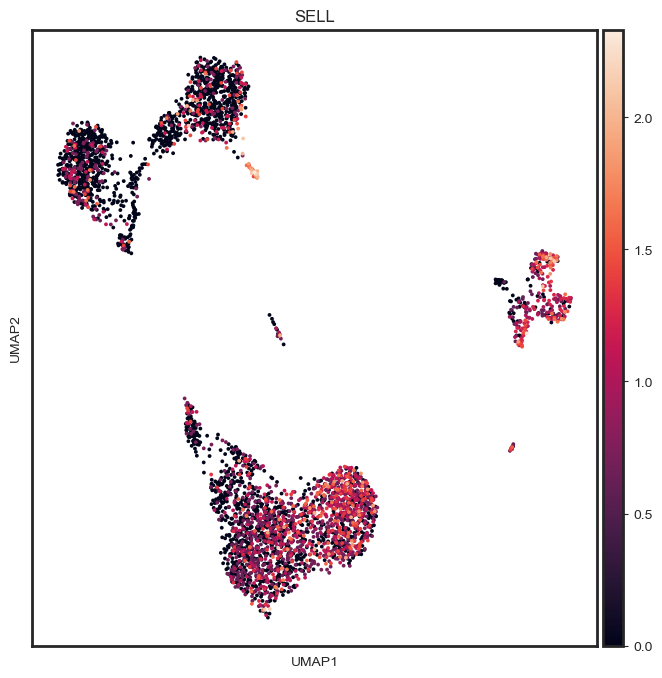

In [101]:
sc.pl.umap(adata_forcycle, color='SELL')

### Use the cell cycle gene list summarized by Triosh et al. to calculate the cc score

In [102]:
cc_genes = pd.read_excel('Triosh_cc.xlsx')

In [103]:
s_genes = cc_genes['G1/S'].dropna()
g2m_genes = cc_genes['G2/M'].dropna()

s_genes_mm_ens = adata_forcycle.var_names[np.in1d(adata_forcycle.var_names, s_genes)]
g2m_genes_mm_ens = adata_forcycle.var_names[np.in1d(adata_forcycle.var_names, g2m_genes)]

In [104]:
sc.tl.score_genes_cell_cycle(adata_forcycle, s_genes=s_genes_mm_ens, g2m_genes=g2m_genes_mm_ens)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    699 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    739 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


### Visualize the cell phases of the co-cultured cells

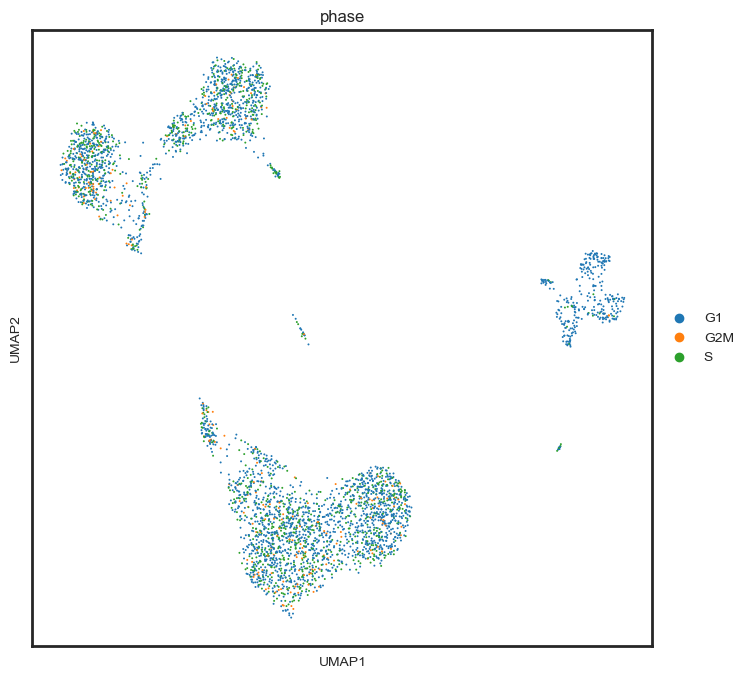

In [105]:
sc.pl.umap(adata_forcycle, color='phase',size = 8)

In [106]:
Sscore = adata_forcycle.obs['S_score'].values.tolist()
G2Mscore = adata_forcycle.obs['G2M_score'].values.tolist()
S_G2M_diff = adata_forcycle.obs['S_score'] - adata_forcycle.obs['G2M_score']
S_G2M_diff = S_G2M_diff.values.tolist()

In [107]:
adata.uns['allgenes'] = list(adata.var_names)
adata.obs['S_score'] = adata_forcycle.obs['S_score']
adata.obs['G2M_score'] = adata_forcycle.obs['G2M_score']
adata.obs['S_G2M_diff'] = adata.obs['S_score'] - adata.obs['G2M_score']
adata.obs['phase'] = adata_forcycle.obs['phase']

In [108]:
colnames = adata.obs_names
rownames = adata.var_names
mt_frac = adata.obs['mt_frac']
S_G2M_diff = adata.obs['S_score'] - adata.obs['G2M_score']
S_G2M_diff = S_G2M_diff.values.tolist()

### Construct the Seurat object

In [109]:
counts = adata.X.A.T

In [110]:
%R -i counts -i colnames -i rownames -i S_G2M_diff -i mt_frac

In [111]:
%%R
colnames(counts) = colnames
rownames(counts) = rownames

srat <- CreateSeuratObject(counts = counts, min.cells = 0, min.features = 0, assay = "RNA")

srat[["S_G2M_diff"]] = S_G2M_diff
srat[["mt_frac"]] = mt_frac

In [112]:
%%R
srat = SCTransform(object = srat, min_cells = 0, verbose = FALSE, vst.flavor = "v2", vars.to.regress = c("S_G2M_diff","mt_frac")) #c("G2Mscore","Sscore"))

srat = RunPCA(srat, verbose = FALSE)

In [113]:
%%R -o HVG -o varExplained -o PCs -o mat -o pca

HVG = VariableFeatures(srat)

mat <- Seurat::GetAssayData(object = srat, slot = 'scale.data')
pca <- srat[["pca"]]

# Get the total variance:
total_variance <- sum(matrixStats::rowVars(mat))

eigValues = (pca@stdev)^2  ## EigenValues
varExplained = eigValues / total_variance

PCs = Loadings(srat, reduction = "pca")

In [125]:
%%R -o X_pca
X_pca =pca@cell.embeddings

In [126]:
%%R -o counts -o logcounts

counts = srat[["SCT"]]@counts
logcounts = srat[["SCT"]]@data

In [127]:
import anndata
adata1 = anndata.AnnData(X = logcounts.T)
adata1.var_names = adata.var_names
adata1.obs_names = adata.obs_names
adata1.uns['scaled'] = mat.T
adata1.layers['counts'] = counts.T
adata1.layers['logcounts'] = logcounts.T
adata1.obsm['X_pca'] = X_pca
adata1.obs['phase'] = adata.obs['phase']
adata1.obs['antibody'] = adata.obs['antibody'] 

In [128]:
adata1.varm['PCs'] = np.zeros([np.shape(adata.X.A)[1],50])
for i in range(0,50):
    genename = HVG[i]
    adata1.varm['PCs'][adata1.var_names == genename,:] = PCs[i,:]

In [129]:
adata1.obs['n_counts'] = adata1.layers['counts'].sum(1)
adata1.obs['n_genes'] = (adata1.layers['counts'] > 0).sum(1)
adata1.var['highly_variable'] = adata1.var_names.isin(HVG)
adata1.uns['pca'] = dict({'variance_ratio': varExplained})

In [130]:
mt_gene_mask = [gene.startswith('MT-') for gene in adata1.var_names]
adata1.obs['mt_frac'] = np.array(adata1.layers['counts'][:, mt_gene_mask].sum(1).ravel())[0]/adata1.obs['n_counts']

In [131]:
ribo_gene_mask = [gene.startswith('RPL') or gene.startswith('RPS') for gene in adata1.var_names]
adata1.obs['ribo_frac'] = np.array(adata1.layers['counts'][:, ribo_gene_mask].sum(1).ravel())[0]/adata1.obs['n_counts']

In [133]:
sc.pp.neighbors(adata1)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [134]:
sc.tl.leiden(adata1, resolution = 0.5)

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


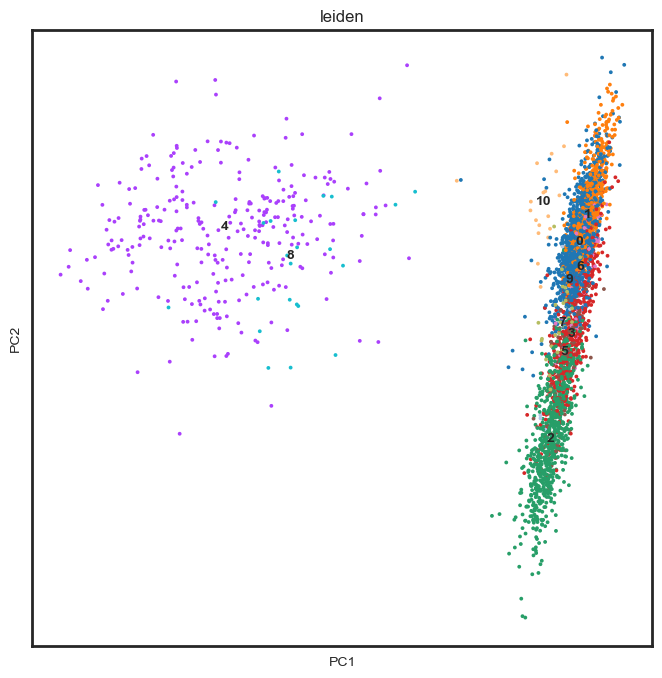

In [135]:
sc.pl.pca(adata1, color='leiden', legend_loc = 'on data')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


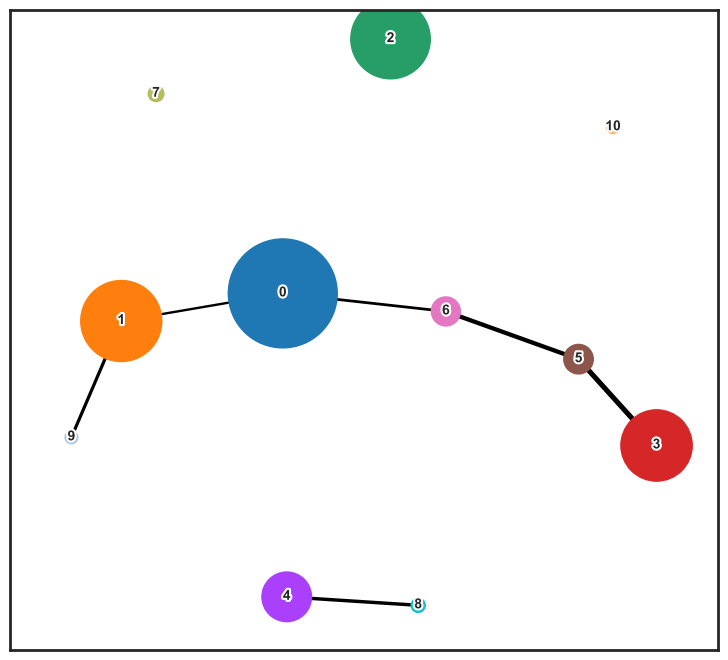

In [136]:
sc.tl.paga(adata1, groups='leiden')
sc.pl.paga(adata1,threshold = 0.2, labels=None, fontsize = 10, fontoutline = 3,node_size_scale = 3,node_size_power = 1,random_state = 0)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


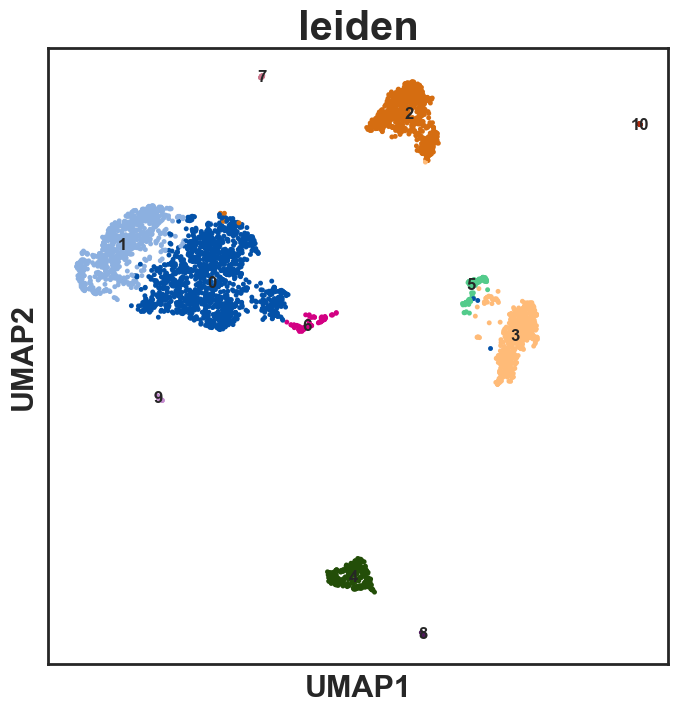

In [138]:
sc.tl.umap(adata1, min_dist = 0.01, spread = 2,init_pos = 'paga')
plt.close()
plt.rcParams['axes.linewidth'] = 2
fig = sc.pl.umap(adata1, color = ['leiden'],size = 50, legend_loc = 'on data', palette  = my_pallete, ncols = 4, cmap = my_cmap, return_fig = True, legend_fontsize = 'large')
ax = fig.get_axes()
for i in range(0,len(ax)):
    ax[i].xaxis.label.set_fontsize(22)
    ax[i].xaxis.label.set_fontweight('bold')
    ax[i].yaxis.label.set_fontsize(22)
    ax[i].title.set_fontsize(30)
    ax[i].yaxis.label.set_fontweight('bold')
    ax[i].title.set_fontweight('bold')
plt.savefig('overall_map_withunmatched.png')

In [12]:
antibody= pd.read_csv('GSM4288255_Antibodies_count.csv.gz',sep='\t',index_col=0)

In [13]:
adata1.obs['antibody'] = np.zeros([adata1.shape[0],1])
for i in adata1.obs_names:
    adata1.obs.loc[i,'antibody'] = antibody.loc[i,'CD45RA_Ab']

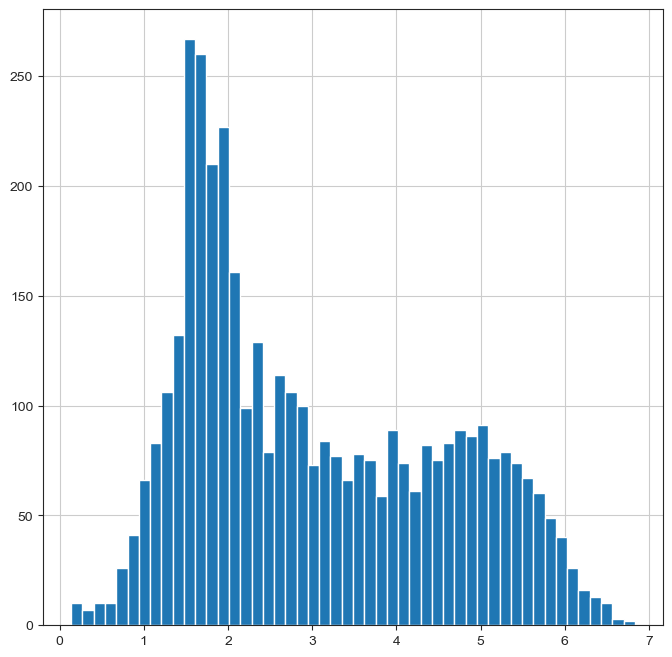

In [14]:
p1 = adata1.obs['antibody'].hist(bins = 50)

In [15]:
import skimage
#two-peaks thresholding is a classic question in image processing so I just borrow their function
t = skimage.filters.threshold_otsu(adata1.obs['antibody'].values)
print("Found automatic threshold t = {}.".format(t))

Found automatic threshold t = 3.3407447370357746.


In [16]:
CD45RA_neg = adata1[adata1.obs['antibody']<=t-0.5]

In [17]:
CD45RA_pos = adata1[adata1.obs['antibody']>=t+0.5]

In [18]:
adata_concat = CD45RA_pos.concatenate(CD45RA_neg, batch_categories=['Positive', 'Negative'])